fetchPipelinesInfo_v4 Done
fetchDatasetsInfo_v4 Done


<ipython-input-54-c0d4257afb3b>:267: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(patches, labels = sortedStatistic.keys(), loc=(1, 0.1), fontsize=13)


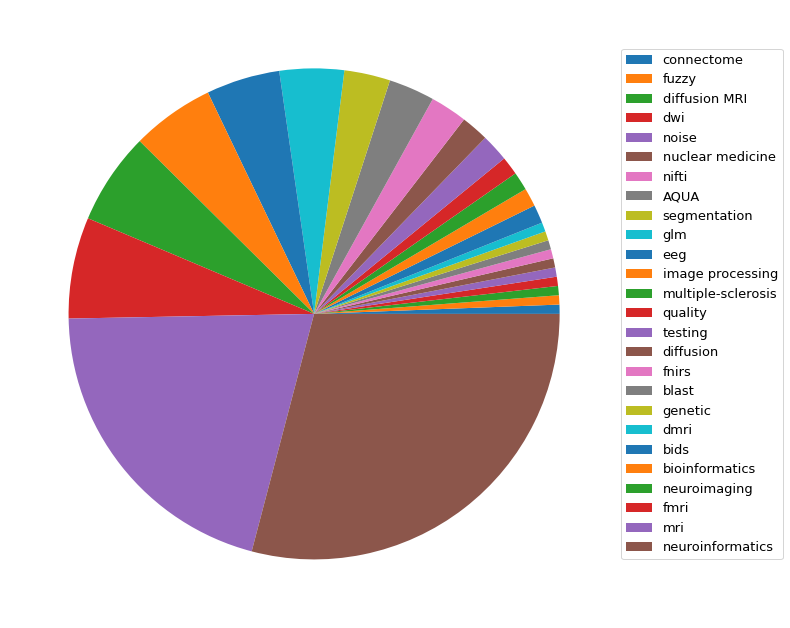

<ipython-input-54-c0d4257afb3b>:289: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(patches, labels = sortedStatistic.keys(), loc=(1, 0), fontsize=11, ncol=2)


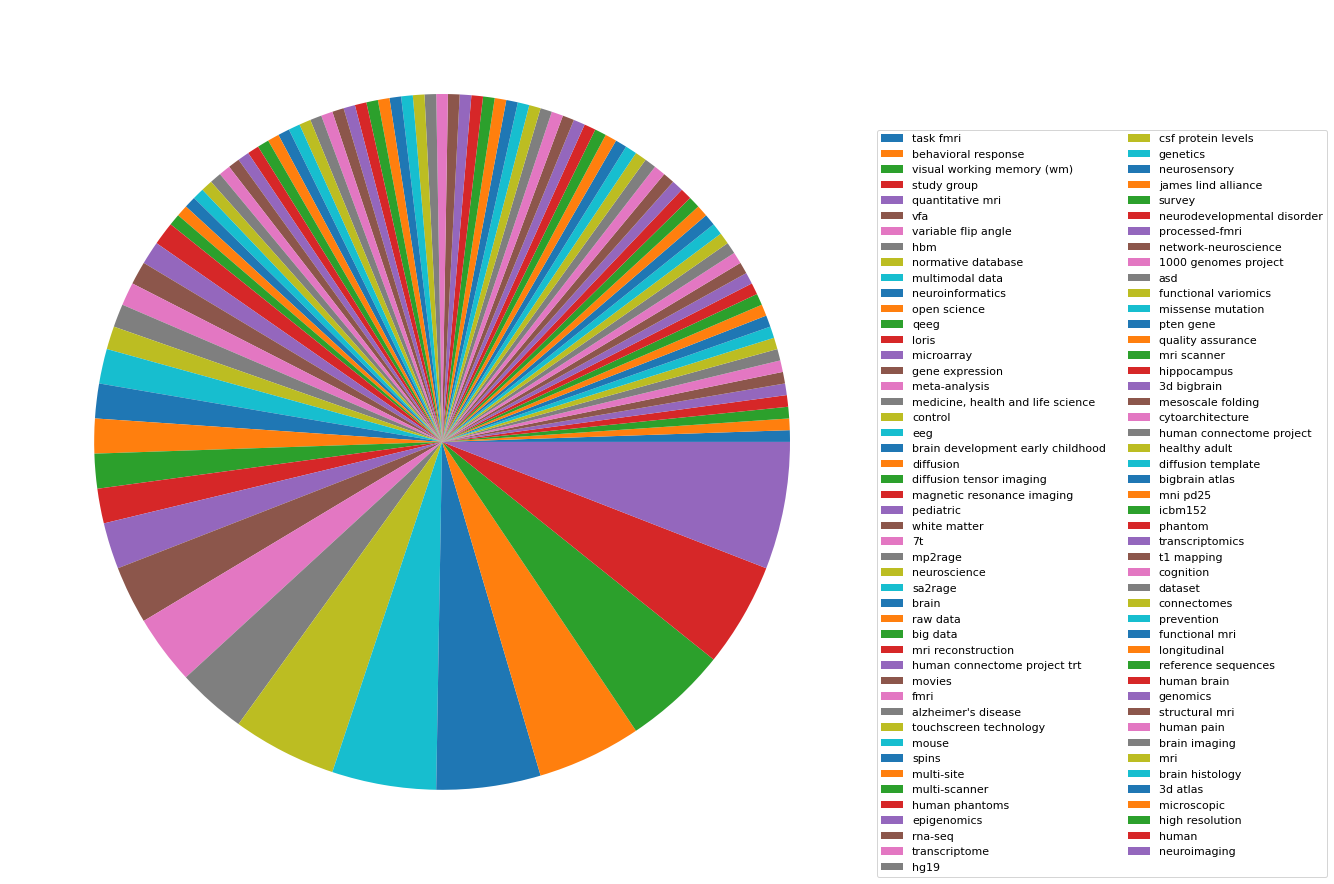

getPipelinesAndDatasetsStatisctic_PieChart_v4 Done


In [54]:
import os, sys
from boutiques.searcher import Searcher
from boutiques.puller import Puller
import json
import git
import numpy as np
import matplotlib.pyplot as plt
import shutil

pipelineDescriptors_FN = os.path.join(os.getcwd(), "all_descriptors.json")
figuresFolder = os.path.join(os.getcwd(), "..", "figures")

def fetchPipelinesInfo_v4(update = False):
    if update == False:
        if os.path.exists(pipelineDescriptors_FN):
            print("fetchPipelinesInfo_v4 Done")
            return
        
    ############################vvvvvvvvvvvvvvvvvvvvvv This section is from : /conp-portal/app/threads.py 
    searcher = Searcher(query=None, max_results=100, no_trunc=True, verbose=True)
    all_descriptors = searcher.search()
    # then pull every single descriptor
    all_descriptor_ids = list(map(lambda x: x["ID"], all_descriptors))
    files = Puller(all_descriptor_ids).pull()

    # fetch every single descriptor into one file
    detailed_all_descriptors = list(map(lambda f: json.load(open(f, 'r')), files))
    
    # store data in cache
    with open(pipelineDescriptors_FN, "w") as f:
        json.dump(all_descriptors, f, indent=4)

    #with open(detailed_all_descriptors_File, "w") as f:
    #    json.dump(detailed_all_descriptors, f, indent=4)
    ############################^^^^^^^^^^^^^^^^^^^^^^ This section is from : /conp-portal/app/threads.py 
    print("fetchPipelinesInfor_v4 Done")
    
    
def fetchDatasetsInfo_v4(update = False):
    #Get information about datasets
    RECOMMENDER_V4_DATASETS_PATH = os.path.join(os.getenv("HOME"), ".cache/recommender-v4-datasets")
    if not os.path.exists(RECOMMENDER_V4_DATASETS_PATH):
        os.mkdir(RECOMMENDER_V4_DATASETS_PATH)

    repository = git.Git(RECOMMENDER_V4_DATASETS_PATH)
    
    
    #This command slows down the procedure to fetch and clone all files again
    if update == True:
        if os.path.exists(RECOMMENDER_V4_DATASETS_PATH):
            shutil.rmtree(RECOMMENDER_V4_DATASETS_PATH)
            os.mkdir(RECOMMENDER_V4_DATASETS_PATH)
        repository.clone("https://github.com/CONP-PCNO/conp-dataset.git", recursive=True, branch='master', progress=True)
    else:
        if not os.path.exists(RECOMMENDER_V4_DATASETS_PATH):
            repository.clone("https://github.com/CONP-PCNO/conp-dataset.git", recursive=True, branch='master', progress=True)
        #else:
        #    repository.checkout('master') #.fetch("https://github.com/CONP-PCNO/conp-dataset.git", recursive=True, branch='master', progress=True)
        #    repository.fetch()

    
    print("fetchDatasetsInfo_v4 Done")

'''
def func(pct, allvals):
    absolute = int(round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n({:d} g)".format(pct, absolute)
'''

def getPipelinesAndDatasetsStatisctic_PieChart_v4():

    
    with open(pipelineDescriptors_FN) as f:
        all_descriptors = json.load(f)
    
    #Get statistics for TAGS
    pipelineDomains = []
    for pipelineDescriptor in all_descriptors:
        for tag in pipelineDescriptor['TAGS'].split(','):
            if 'domain' in tag:
                tagName = tag.split(':')[1]
                if tagName not in pipelineDomains:
                    pipelineDomains += [tagName]
    
    #Stores statisctics
    statistic = {
        "Pipelines TAGS": {}, 
        "Pipelines CONTAINER":{"docker" : 0, "singularity": 0}, 
        "Datasets Format": {}, 
        "Datasets Modality": {}, 
        "Datasets Keyword": {}, 
        "Datasets File Size": [],
        "Datasets Total Size (GB)": 0,
        "Datasets Num Of Files": 0,
        "Datasets Subjects": 0,
        
    }
    
    for pipelineDomain in pipelineDomains:
        statistic["Pipelines TAGS"][pipelineDomain] = 0
        
    for pipelineDescriptor in all_descriptors:
        if pipelineDescriptor["ID"] != "zenodo.3879740":  #there are 2 "TITLE": "BEst"
            for pipelineDomain in pipelineDomains:
                if pipelineDomain in pipelineDescriptor['TAGS']:
                    statistic["Pipelines TAGS"][pipelineDomain] += 1

            #Get statistics for CONTAINER
            if "docker" in pipelineDescriptor["CONTAINER"]:
                statistic["Pipelines CONTAINER"]["docker"] += 1
            if "singularity" in pipelineDescriptor["CONTAINER"]:
                statistic["Pipelines CONTAINER"]["singularity"] += 1
            
    
    RECOMMENDER_V4_DATASETS_PATH = os.path.join(os.getenv("HOME"), ".cache/recommender-v4-datasets")

    crowlerFolderAddressList = os.listdir(os.path.join(RECOMMENDER_V4_DATASETS_PATH, "conp-dataset", "projects"))
    for index, item in enumerate(crowlerFolderAddressList):
        crowlerFolderAddressList[index] = os.path.join(RECOMMENDER_V4_DATASETS_PATH, "conp-dataset", "projects", item)

    datasetDescriptorFileAddress = []
    for folder in crowlerFolderAddressList:
        if os.path.isdir(folder):
            if os.path.exists(os.path.join(folder, "DATS.json")):
                datasetDescriptorFileAddress += [os.path.join(RECOMMENDER_V4_DATASETS_PATH, folder, "DATS.json")]
            else:
                subfolderList = os.listdir(os.path.join(RECOMMENDER_V4_DATASETS_PATH, folder))
                for index, item in enumerate(subfolderList):
                    subfolderList[index] = os.path.join(RECOMMENDER_V4_DATASETS_PATH, folder, item)
                crowlerFolderAddressList += subfolderList

    allDatasetDescriptors = []
    for datasetDescriptor in datasetDescriptorFileAddress:
        with open(datasetDescriptor) as f:
            allDatasetDescriptors += [json.load(f)]
    
    datasetFormats = []
    datasetModalities = []
    datasetKeywords = []
    for datasetDescriptor in allDatasetDescriptors:
        if "formats" in datasetDescriptor["distributions"][0].keys():
            for datasetFormat in datasetDescriptor["distributions"][0]["formats"]:
                if datasetFormat not in datasetFormats:
                    datasetFormats += [datasetFormat]
    
    for datasetDescriptor in allDatasetDescriptors:
        for t in datasetDescriptor.get('types', []):
            info = t.get('information', {})
            modality = info.get('value', None)
            if (modality is not None) and (modality.lower() not in datasetModalities):
                datasetModalities.append(modality.lower())
        for t in datasetDescriptor.get('keywords', []):
            keyword = t.get('value', None)
            if (keyword is not None) and (keyword not in datasetKeywords):
                datasetKeywords.append(keyword.lower())
        
    for datasetFormat in datasetFormats:
        statistic["Datasets Format"][datasetFormat] = 0
    for datasetModality in datasetModalities:
        statistic["Datasets Modality"][datasetModality] = 0
    for datasetKeyword in datasetKeywords:
        statistic["Datasets Keyword"][datasetKeyword] = 0

    statistic["Datasets Total Size (GB)"] = 0
    for datasetDescriptorFile in datasetDescriptorFileAddress:
        with open(datasetDescriptorFile) as f:
            datasetDescriptor = json.load(f)

            if "formats" in datasetDescriptor["distributions"][0].keys():
                for datasetFormat in datasetDescriptor["distributions"][0]["formats"]:
                    statistic["Datasets Format"][datasetFormat] += 1

            for t in datasetDescriptor.get('types', []):
                info = t.get('information', {})
                modality = info.get('value', None)
                if (modality is not None):
                    statistic["Datasets Modality"][modality.lower()] += 1

            for t in datasetDescriptor.get('keywords', []):
                keyword = t.get('value', {})
                if (keyword is not None):
                    statistic["Datasets Keyword"][keyword.lower()] += 1


            dists = datasetDescriptor.get('distributions', None)
            if dists:
                if not type(dists) == list:
                    if dists.get('@type', '') == 'DatasetDistribution':
                        dist = dists
                    else:
                        dist = {}
                else:
                    # Taking the first distribution size. (arbitrary choice)
                    dist = dists[0]

                size = float(dist.get('size', 0))
                unit = dist.get('unit', {}).get('value', '')

                # Some data values from the DATS are not user friendly so
                # If size > 1000, divide n times until it is < 1000 and increment the units from the array
                units = ['B', 'KB', 'MB', 'GB', 'TB', 'PB', 'EB']
                count = 0

                while size > 1000:
                    size /= 1000
                    count += 1

                size = round(size, 1)
                unit = units[units.index(unit) + count]
                statistic["Datasets File Size"] += ["{} {}".format(size, unit)]

                if unit == 'B':
                    statistic["Datasets Total Size (GB)"] += size / 1000000000
                elif unit == 'KB':
                    statistic["Datasets Total Size (GB)"] += size / 1000000
                elif unit == 'MB':
                    statistic["Datasets Total Size (GB)"] += size / 1000
                elif unit == 'GB':
                    statistic["Datasets Total Size (GB)"] += size
                elif unit == 'TB':
                    statistic["Datasets Total Size (GB)"] += size * 1000
                elif unit == 'PB':
                    statistic["Datasets Total Size (GB)"] += size * 1000000
                elif unit == 'EB':
                    statistic["Datasets Total Size (GB)"] += size * 1000000000

            count = 0
            extraprops = datasetDescriptor.get('extraProperties', {})
            for prop in extraprops:
                if prop.get('category') == 'files':
                    for x in prop.get('values', []):
                        if isinstance(x['value'], str):
                            count += int(x['value'].replace(",", ""))
                        else:
                            count += x['value']
            statistic["Datasets Num Of Files"] += count

            count = 0
            extraprops = datasetDescriptor.get('extraProperties', {})
            for prop in extraprops:
                if prop.get('category') == 'subjects':
                    for x in prop.get('values', []):
                        if isinstance(x['value'], str):
                            count += int(x['value'].replace(",", ""))
                        else:
                            count += x['value']
            statistic["Datasets Subjects"] += count

    #remove "" from datasets keywords
    if 'canadian-open-neuroscience-platform' in statistic["Datasets Keyword"].keys():
        del statistic["Datasets Keyword"]['canadian-open-neuroscience-platform']
    
    
    #Pipelines TAGS
    for item in list(statistic["Pipelines TAGS"]):
        if statistic["Pipelines TAGS"][item] == 0:
            statistic["Pipelines TAGS"].pop(item)
            
    sortedStatistic = {k: v for k, v in sorted(statistic["Pipelines TAGS"].items(), key=lambda item: item[1], reverse=False)}
    
    y_pos = np.arange(len(sortedStatistic.keys()))
    plt.subplots(figsize=(11,16))
    #plt.barh(y_pos, sortedStatistic.values(), align='center', alpha=1, color='red') 
    patches, texts = plt.pie(sortedStatistic.values())#, labels = sortedStatistic.keys())#, autopct=lambda pct: func(pct, sortedStatistic.keys())) 
    #for item in texts:
    #    item.set_fontsize(15)
    plt.legend(patches, labels = sortedStatistic.keys(), loc=(1, 0.1), fontsize=13)
    
    plt.margins(y=0.01)
    
    plt.savefig(os.path.join(figuresFolder, 'Pipelines Tag Pie Chart.pdf'), bbox_inches="tight")
    plt.show(block=False)
    plt.pause(1)
    plt.close()
    
    #Datasets Type
    for item in list(statistic["Datasets Keyword"]):
        if statistic["Datasets Keyword"][item] == 0:
            statistic["Datasets Keyword"].pop(item)
    
    sortedStatistic = {k: v for k, v in sorted(statistic["Datasets Keyword"].items(), key=lambda item: item[1], reverse=False)}
    
    y_pos = np.arange(len(sortedStatistic.values()))
    plt.subplots(figsize=(30,16))
    #plt.barh(y_pos, sortedStatistic.values(), align='center', alpha=1, color='blue') 
    patches, texts = plt.pie(sortedStatistic.values())#, labels = sortedStatistic.keys()) 
    #for item in texts:
    #    item.set_fontsize(5)
    plt.legend(patches, labels = sortedStatistic.keys(), loc=(1, 0), fontsize=11, ncol=2)
    
    plt.margins(y=0.01)
    #plt.yticks(y_pos, sortedStatistic.keys(), fontsize=18)  
    
    
    #xValues = [*range(0, max(sortedStatistic.values()) + 1, 1)]
    #plt.xticks(xValues, xValues, fontsize=18)
    #plt.xlabel('Number of Datasets', fontsize=18)
    #plt.ylabel('Dataset Keyword', fontsize=18)
    #plt.savefig(os.path.join(figuresFolder, 'Datasets Keyword Pie Chart.jpg'), bbox_inches="tight")
    plt.savefig(os.path.join(figuresFolder, 'Datasets Keyword Pie Chart.pdf'), bbox_inches="tight")
    plt.show(block=False)
    plt.pause(1)
    plt.close()
    
    
    print("getPipelinesAndDatasetsStatisctic_PieChart_v4 Done")
    
fetchPipelinesInfo_v4(update = False)            
fetchDatasetsInfo_v4(update = False)            
getPipelinesAndDatasetsStatisctic_PieChart_v4()

